#**Importing the file**

In [1]:
%env CUDA_LAUNCH_BLOCKING=1

env: CUDA_LAUNCH_BLOCKING=1


In [2]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/ellamguest/online-misogyny-eacl2021/refs/heads/main/data/final_labels.csv')
df.head()


,entry_id,link_id,parent_id,entry_utc,subreddit,author,body,image,label_date,week,group,sheet_order,level_1,level_2,level_3,strength,highlight,split
0,exoxn7,t3_exoxn7,NaN,1580652620,badwomensanatomy,doggodone,Do you have the skin of a 80 year old grandma?...,Yes,17-02-2020,1,1,"(1,)",Nonmisogynistic,None_of_the_categories,NaN,NaN,NaN,train
1,fgb3bdv,t3_exoxn7,t3_exoxn7,1580658139,badwomensanatomy,Machaeon,This is taking a grain of truth and extrapolat...,NaN,17-02-2020,1,1,"(1, 1)",Nonmisogynistic,None_of_the_categories,NaN,NaN,NaN,train
2,fgc6tlu,t3_exoxn7,t3_exoxn7,1580669695,badwomensanatomy,CuniculusVincitOmnia,Honestly my favorite thing about this is that ...,NaN,17-02-2020,1,1,"(1, 2)",Nonmisogynistic,None_of_the_categories,NaN,NaN,NaN,test
3,fge6msg,t3_exoxn7,t1_fgc6tlu,1580692566,badwomensanatomy,its331am,Source? Doesnt sound right to me idk,NaN,17-02-2020,1,1,"(1, 2, 1)",Nonmisogynistic,None_of_the_categories,NaN,NaN,NaN,test
4,fgawus5,t3_exoxn7,t3_exoxn7,1580656280,badwomensanatomy,JaxDefore,"Damn, I saw a movie in which the old woman bat...",NaN,17-02-2020,1,1,"(1, 3)",Misogynistic,Derogation,Moral_inferiority,Nature of the abuse is Implicit,old woman bathed in the blood if virgins,train


## **Preprocessing the Data**

In [3]:
df["body"] = df["body"].fillna("[UNK]")
df["level_1"] = df["level_1"].fillna("None")
df["level_2"] = df["level_2"].fillna("None")
df["level_3"] = df["level_3"].fillna("None")

level_1_mapping = {"Misogynistic": 0,
                   "Nonmisogynistic": 1}

level_2_mapping = {"Pejorative": 0,
                   "Treatment": 1,
                   "Derogation": 2,
                   "Personal Attack":3,
                   "Non-Misogynistic Attack":4,
                   "Counter Speech":5,
                   "None":6}

level_3_mapping = {"Non-Misogynistic Personal Attack": 0,
                   "Counter Speech": 1,
                   "None of the categories": 2}

df["level_1"] = df["level_1"].map(level_1_mapping)
df["level_2"] = df["level_2"].map(level_2_mapping)
df["level_3"] = df["level_3"].map(level_3_mapping)

train_df = df[df["split"] == "train"]
test_df = df[df["split"] == "test"]

train_texts, train_labels_1, train_labels_2, train_labels_3 = train_df["body"].tolist(), train_df["level_1"].tolist(), train_df["level_2"].tolist(), train_df["level_3"].tolist()
test_texts, test_labels_1, test_labels_2, test_labels_3 = test_df["body"].tolist(), test_df["level_1"].tolist(), test_df["level_2"].tolist(), test_df["level_3"].tolist()

## **Tokenization and preparation**

In [4]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_text(text):
    return tokenizer.encode(text, padding="max_length", truncation=True, max_length=521)

train_encodings = tokenizer(train_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

##  **Defining a Custom Multi-Task Dataset**

In [5]:
import pandas as pd
import torch
from torch.utils.data import Dataset

class MultiTaskMisogynyDataset(Dataset):
  def __init__(self, encodings, labels_1, labels_2, labels_3):
    self.encodings = encodings
    self.labels_1 = labels_1
    self.labels_2 = [min(max(0, int(label)), 6) if not pd.isnull(label) else 0 for label in labels_2]
    self.labels_3 = [min(max(0, int(label)), 2) if not pd.isnull(label) else 0 for label in labels_3]

  def __len__(self):
    return len(self.labels_1)

  def __getitem__(self, idx):
     item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
     item['labels_1'] = torch.tensor(self.labels_1[idx], dtype=torch.long)
     item['labels_2'] = torch.tensor(self.labels_2[idx] , dtype=torch.long) # I am having to create this because
     item['labels_3'] = torch.tensor(self.labels_3[idx] , dtype=torch.long) # it apparently goes over the limit of int64
     return item

train_dataset = MultiTaskMisogynyDataset(train_encodings, train_labels_1, train_labels_2, train_labels_3)

## **Modifying BERT for multi task Learning**

In [6]:
from transformers import BertModel
import torch.nn as nn

class MultiTaskBERT(nn.Module):
  def __init__(self, model_name, num_labels_1, num_labels_2, num_labels_3):
    super(MultiTaskBERT, self).__init__()
    self.bert = BertModel.from_pretrained(model_name)

    #classifiers for each level
    self.classifier_1 = nn.Linear(self.bert.config.hidden_size, num_labels_1)
    self.classifier_2 = nn.Linear(self.bert.config.hidden_size, num_labels_2)
    self.classifier_3 = nn.Linear(self.bert.config.hidden_size, num_labels_3)

    self.dropout = nn.Dropout(0.2)

  def forward(self, input_ids, attention_mask):
    outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
    pooled_output = outputs.pooler_output

    logits_1 = self.classifier_1(self.dropout(pooled_output))
    logits_2 = self.classifier_2(self.dropout(pooled_output))
    logits_3 = self.classifier_3(self.dropout(pooled_output))

    return logits_1, logits_2, logits_3

##  **Training Loop**

In [7]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MultiTaskBERT("bert-base-uncased", num_labels_1=2, num_labels_2=7, num_labels_3=3).to(device)
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

def train_model(model, train_loader, optimizer, criterion, epochs = 4):

  model.train()
  for epoch in range(epochs):
    total_loss = 0
    for batch in train_loader:
      optimizer.zero_grad()

      input_ids = batch["input_ids"].to(device)
      attention_mask = batch["attention_mask"].to(device)
      labels_1 = batch["labels_1"].to(device)
      labels_2 = batch["labels_2"].to(device)
      labels_3 = batch["labels_3"].to(device)

      logits_1, logits_2, logits_3 = model(input_ids, attention_mask)

      loss_1 = criterion(logits_1, labels_1)
      loss_2 = criterion(logits_2, labels_2)
      loss_3 = criterion(logits_3, labels_3)

      loss = loss_1 + loss_2 + loss_3

      if torch.isnan(loss).any():
        print("Loss is NaN")
        optimizer.zero_grad()
        continue

      loss.backward()
      optimizer.step()
      total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader)}")

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
train_model(model, train_loader, optimizer, criterion, epochs=4)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch 1/4, Loss: 0.6004727826224453
Epoch 2/4, Loss: 0.32476068659059953
Epoch 3/4, Loss: 0.186538819167027
Epoch 4/4, Loss: 0.11106869823682917


## **Evaluation function**

In [9]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np

def evaluate_model(model, test_loader, device):
  model.eval()

  all_labels_1, all_preds_1 = [], []
  all_labels_2, all_preds_2 = [], []
  all_labels_3, all_preds_3 = [], []

  with torch.no_grad():
    for batch in test_loader:
      input_ids = batch["input_ids"].to(device)
      attention_mask = batch["attention_mask"].to(device)
      labels_1 = batch["labels_1"].to(device)
      labels_2 = batch["labels_2"].to(device)
      labels_3 = batch["labels_3"].to(device)

      logits_1, logits_2, logits_3 = model(input_ids, attention_mask)

      preds_1 = torch.argmax(logits_1, dim=1)
      preds_2 = torch.argmax(logits_2, dim=1)
      preds_3 = torch.argmax(logits_3, dim=1)

      all_labels_1.extend(labels_1.cpu().numpy())
      all_preds_1.extend(preds_1.cpu().numpy())

      all_labels_2.extend(labels_2.cpu().numpy())
      all_preds_2.extend(preds_2.cpu().numpy())

      all_labels_3.extend(labels_3.cpu().numpy())
      all_preds_3.extend(preds_3.cpu().numpy())

    def compute_metrics(labels, preds):
      accuracy = accuracy_score(labels, preds)
      precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
      return accuracy, precision, recall, f1

    metrics_1 = compute_metrics(all_labels_1, all_preds_1)
    metrics_2 = compute_metrics(all_labels_2, all_preds_2)
    metrics_3 = compute_metrics(all_labels_3, all_preds_3)

    print(f"Level 1 - Accuracy: {metrics_1[0]:.4f}, Precision: {metrics_1[1]:.4f}, Recall: {metrics_1[2]:.4f}, F1: {metrics_1[3]:.4f}")
    print(f"Level 2 - Accuracy: {metrics_2[0]:.4f}, Precision: {metrics_2[1]:.4f}, Recall: {metrics_2[2]:.4f}, F1: {metrics_2[3]:.4f}")
    print(f"Level 3 - Accuracy: {metrics_3[0]:.4f}, Precision: {metrics_3[1]:.4f}, Recall: {metrics_3[2]:.4f}, F1: {metrics_3[3]:.4f}")

    return metrics_1, metrics_2, metrics_3

test_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=False)
metrics_1, metrics_2, metrics_3 = evaluate_model(model, test_loader, device)

Level 1 - Accuracy: 0.9861, Precision: 0.9875, Recall: 0.9861, F1: 0.9865
Level 2 - Accuracy: 0.9783, Precision: 0.9779, Recall: 0.9783, F1: 0.9775
Level 3 - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000


## **Downloading it**

In [30]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, BertConfig
import os

model_dir = "saved_bert_model"

# Save the model and tokenizer
# Create a directory if it doesn't exist
os.makedirs(model_dir, exist_ok=True)

# Save the configuration
config = model.bert.config
config.save_pretrained(model_dir)

# Save the state dict
torch.save(model.state_dict(), os.path.join(model_dir, 'pytorch_model.bin'))

tokenizer.save_pretrained(model_dir)

# Zip the model directory
!zip -r hatebert_model.zip saved_bert_model/

  adding: saved_bert_model/ (stored 0%)
  adding: saved_bert_model/config.json (deflated 48%)
  adding: saved_bert_model/pytorch_model.bin (deflated 7%)
  adding: saved_bert_model/vocab.txt (deflated 53%)
  adding: saved_bert_model/tokenizer_config.json (deflated 75%)
  adding: saved_bert_model/special_tokens_map.json (deflated 42%)


In [32]:
from google.colab import files
files.download("hatebert_model.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Performance Graphs

In [26]:
!pip install matplotlib.pyplot.figure

ERROR: Could not find a version that satisfies the requirement matplotlib.pyplot.figure (from versions: none)
ERROR: No matching distribution found for matplotlib.pyplot.figure


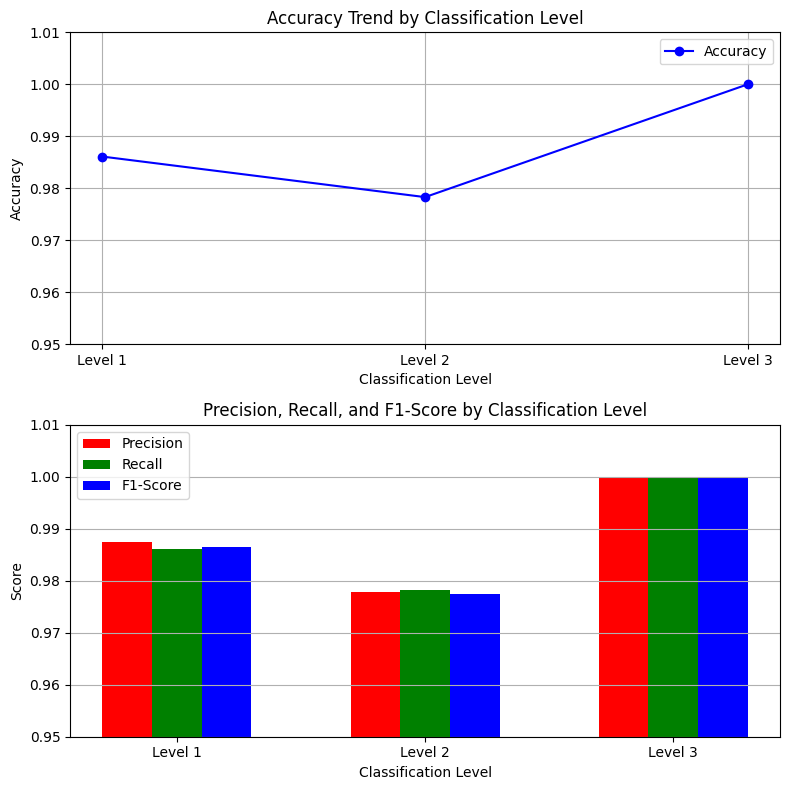

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Data from screenshots
levels = ["Level 1", "Level 2", "Level 3"]
accuracy = [0.9861, 0.9783, 1.0000]
precision = [0.9875, 0.9779, 1.0000]
recall = [0.9861, 0.9783, 1.0000]
f1_score = [0.9865, 0.9775, 1.0000]

# Create a figure with two subplots
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

# Line graph for accuracy trend
axs[0].plot(levels, accuracy, marker='o', linestyle='-', color='b', label="Accuracy")
axs[0].set_title("Accuracy Trend by Classification Level")
axs[0].set_xlabel("Classification Level")
axs[0].set_ylabel("Accuracy")
axs[0].set_ylim(0.95, 1.01)  # Adjust y-axis for better visibility
axs[0].grid(True)
axs[0].legend()

# Bar chart for Precision, Recall, F1-score
bar_width = 0.2
x = np.arange(len(levels))

axs[1].bar(x - bar_width, precision, width=bar_width, color='r', label="Precision")
axs[1].bar(x, recall, width=bar_width, color='g', label="Recall")
axs[1].bar(x + bar_width, f1_score, width=bar_width, color='b', label="F1-Score")

axs[1].set_xticks(x)
axs[1].set_xticklabels(levels)
axs[1].set_title("Precision, Recall, and F1-Score by Classification Level")
axs[1].set_xlabel("Classification Level")
axs[1].set_ylabel("Score")
axs[1].set_ylim(0.95, 1.01)  # Adjust for better visualization
axs[1].legend()
axs[1].grid(axis='y')

plt.tight_layout()
plt.show()
